# Introduction to forward-modelling: TRF
The Temporal Response Function is a generalization of ERP to continuous stimuli/signals. In summary, it is a linear spatio-temporal filter that allows to map one stimuli over electrophysiological data. Alternatively, it can be described as an impulse function, considering the brain (or at least the potential generating process) as a linear time invariant system for the considered stimuli. This model is described as "forward" because we map a stimuli onto neural data, thus following a causal direction. Obviously, this notion could be generalized to other processes where the causal relationship is not as clear, but for simplicity sake, we will only describe the example of sensory processing.

The main advantages of the TRF are that it is multivariate: it can take into account multiple regressor/stimuli and combine them, as well as multiple timelags, it is fast (at least as computed in this package) and it is linear and, therefore, easily explainable. This also implies that it cannot capture non-linearity by itself, but this is mitigated by the ability to use non-linear regressors.



## Importing the library

First, we install the necessary libraries. The spyeeg library contains utility functions that may be useful but most functions relevant to neuroscientists are located in "models", so let's import this one!

In [883]:
%load_ext autoreload
%autoreload 2

# Spyeeg import
import spyeeg.models as models

# Other useful imports
import numpy as np
import matplotlib.pyplot as plt
import mne
import scipy.signal as signal
from sklearn.preprocessing import scale
from scipy.signal import convolve
from sklearn.preprocessing import MinMaxScaler
import colorednoise as cn

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Let's Generate a simple example

To make things simpler, we will create a set of data to vizualize what the TRF package does easily

(0.0, 30.0)

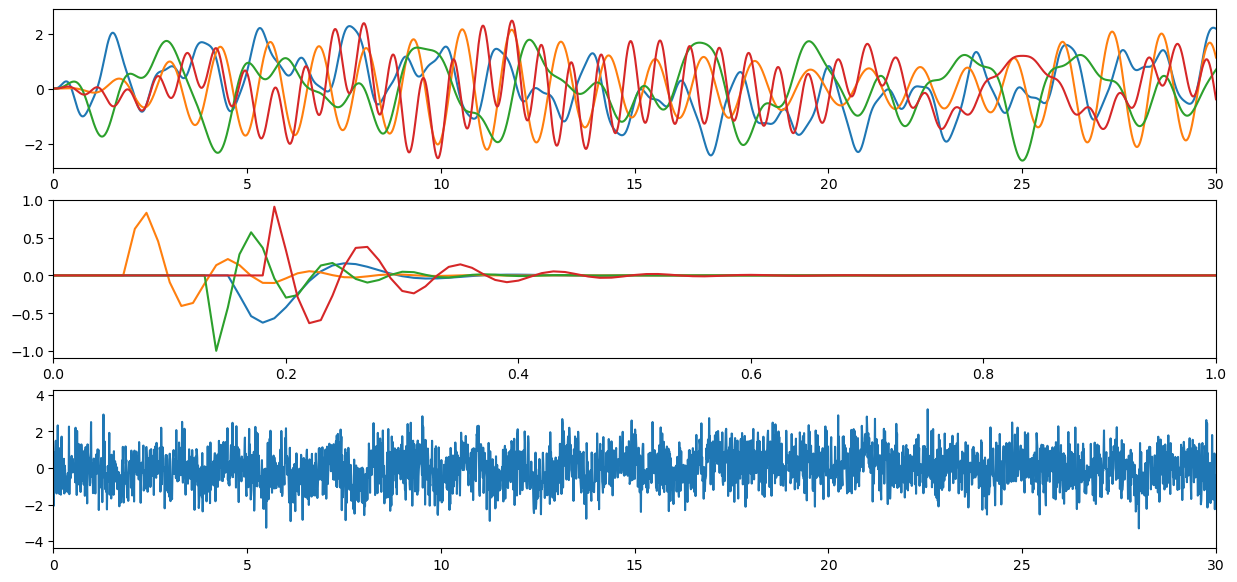

In [1299]:
def simulate_channels(n_feat = 2, n_channels = 3, 
                      fs = 100, T = 60, 
                      noise_level = 0, beta_noise = 0,
                      stim_type = 'discrete', n_pulse = 120, 
                      compression_factor = 1, 
                      impulse_freqs = [0.1,10], decreasing_rates = [0.1,20], delays = [0.06,0.2],
                      random_seed = 0):
    np.random.seed(random_seed)
    n_samples = int(T*fs)
    time_array = np.linspace(0,T,n_samples)
    impulse_responses = np.zeros([n_feat, n_channels,n_samples])
    events = np.zeros([n_feat,n_samples])
    nonlinear_events = np.zeros([n_feat,n_samples])
    response = np.zeros([n_channels,n_samples])
    if stim_type == 'discrete':
        for i_feat in range(n_feat):
            events[i_feat,np.random.randint(0,n_samples,n_pulse)] = np.random.random(n_pulse)
    elif stim_type == 'continuous':
        for i_feat in range(n_feat):
            signal1 = np.random.randint(1,100) * np.sin(2*np.pi*np.random.randint(1,100)*time_array/fs)*np.cos(2*np.pi*np.random.randint(1,100)*time_array/fs)
            signal2 = np.random.randint(1,100) * np.sin(2*np.pi*np.random.randint(1,100)*time_array/fs)*np.cos(2*np.pi*np.random.randint(1,100)*time_array/fs)
            y = convolve(signal1, signal2, 'same')
            events[i_feat,:] = MinMaxScaler(feature_range=(-1,1)).fit_transform(y.reshape(-1, 1)).reshape(-1)

    for i_feat in range(n_feat):
        for i_channel in range(n_channels):
            impulse_responses[i_feat, i_channel,:] = np.roll(np.sin(2*np.pi*np.random.randint(impulse_freqs[0],impulse_freqs[1])*time_array + np.random.rand()*2*np.pi) * np.exp(-time_array*np.random.randint(decreasing_rates[0],decreasing_rates[1])), np.random.randint(int(delays[0]*fs),int(delays[1]*fs)))
                        
    X = events.T

    for i_feat in range(n_feat):
        for i_channel in range(n_channels):
            noise = cn.powerlaw_psd_gaussian(beta_noise, n_samples) * noise_level
            nonlinear_events[i_feat,:] = np.power(np.abs(events[i_feat,:]), compression_factor) * np.sign(events[i_feat,:])
            response[i_channel] += convolve(nonlinear_events[i_feat,:], impulse_responses[i_feat, i_channel,:])[:n_samples] + noise
    
    Y = response.T
    return time_array, X, Y, events, impulse_responses

fs = 100
n_feat = 4
n_channels = 1
T = 600
time_array, X, Y, events, impulse_responses = simulate_channels(n_feat = n_feat, n_channels = n_channels, fs = fs, T = T,  
                                                              stim_type = 'continuous', n_pulse = 120, 
                                                              impulse_freqs = [2,20], decreasing_rates = [10,20], delays = [0.03,0.2],
                                                              compression_factor = 2, 
                                                              noise_level = 1, beta_noise = 0, #0 = white, 1 = pink, 2 = red
                                                              random_seed = 10)

fig, ax = plt.subplots(3,figsize = (15,7), sharex = False)
X = scale(X)
Y = scale(Y)
ax[0].plot(time_array,X)
for i in range(n_feat):
    for j in range(n_channels):
        ax[1].plot(time_array,impulse_responses[i,j])
ax[2].plot(time_array,Y)
ax[0].set_xlim([0,30])
ax[1].set_xlim([0,1])
ax[2].set_xlim([0,30])



## Simple fit

In [1018]:
tmin = -0.3
tmax = 0.7
trf = models.TRF.TRFEstimator(tmin=tmin, tmax=tmax, srate = fs, alpha = [0])
X = stimuli_pos
Y = electrophysiological_data

trf.fit(X, Y)
scores = trf.scores

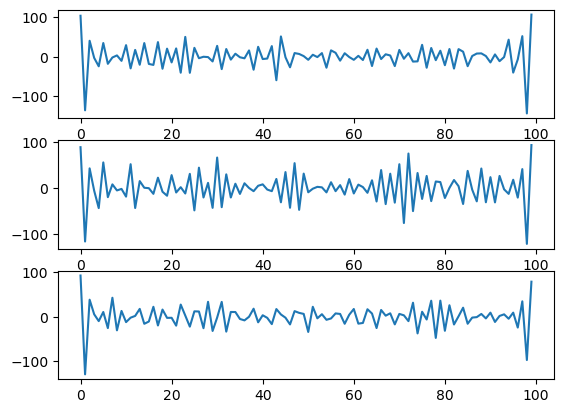

In [795]:
coefficients = trf.get_coef()
fig, ax = plt.subplots(coefficients.shape[2])
for i in range(coefficients.shape[2]):
    ax[i].plot(coefficients[:,0,i,0])

## Effect of Regularization

In [71]:
tmin = -0.1
tmax = 0.5
trf = models.TRF.TRFEstimator(tmin=tmin, tmax=tmax, srate = fs, alpha = [0] + np.logspace(-10,10,20))

In [72]:
X = stimuli_pos
Y = electrophysiological_data

scores = trf.xval_eval(X, Y, scoring = 'R2')

Training/Evaluating fold 1/5
Training/Evaluating fold 2/5
Training/Evaluating fold 3/5
Training/Evaluating fold 4/5
Training/Evaluating fold 5/5
Fitting full model...


Notice: kernels can have higher values because noise adds power. Make a comparison between white and pink noise. Make two different signals for input and compare decoding...etc
Note about R2 and corr: R2 does not mean anything

(0.0, 1.0)

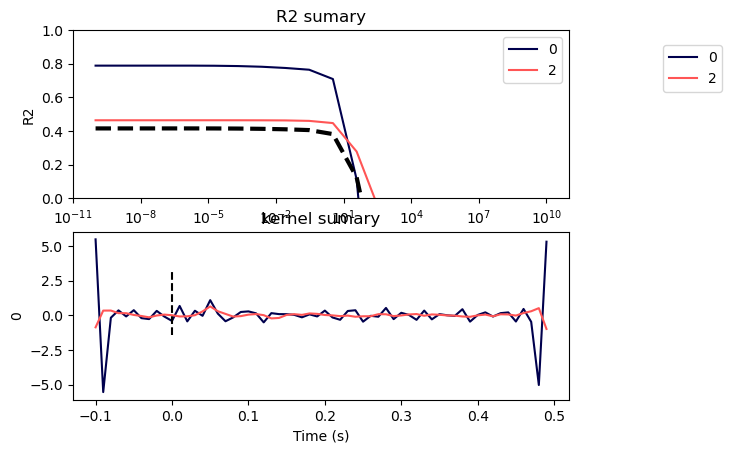

In [73]:
fig, ax = plt.subplots(2)

trf.plot_score(figax = (fig, ax[0]),minR2 = 0, color_type = 'seismic')
trf.plot_kernel(figax = (fig, ax[1]),minR2 = 0, color_type = 'seismic')
ax[0].set_ylim(0,1)

## Effect of scaling

Scaling is not only a good idea to fit the data uniformly, it is also practical as the R2 we compute corresponds to the out of distribution R2. (see metrics_example)

In [3]:
tmin = -0.1
tmax = 0.5
trf1 = models.TRF.TRFEstimator(tmin=tmin, tmax=tmax, srate = fs, alpha = [0] + np.logspace(-2,3,10))
trf2 = models.TRF.TRFEstimator(tmin=tmin, tmax=tmax, srate = fs, alpha = [0] + np.logspace(-2,3,10))

In [4]:
X1 = scale(stimuli_pos)
X2 = scale(stimuli_neg)
Y = scale(electrophysiological_data)

scores1 = trf1.xval_eval(X1, Y, scoring = 'R2')
scores2 = trf2.xval_eval(X2, Y, scoring = 'R2')

Training/Evaluating fold 1/5
Training/Evaluating fold 2/5
Training/Evaluating fold 3/5
Training/Evaluating fold 4/5
Training/Evaluating fold 5/5
Fitting full model...
Training/Evaluating fold 1/5
Training/Evaluating fold 2/5
Training/Evaluating fold 3/5
Training/Evaluating fold 4/5
Training/Evaluating fold 5/5
Fitting full model...


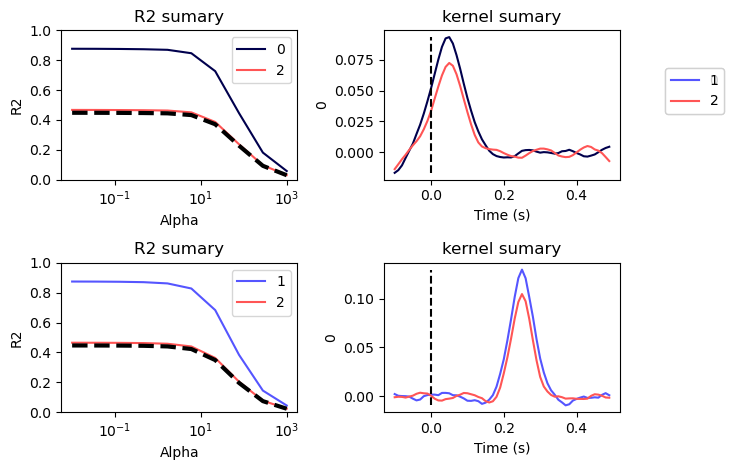

In [5]:
fig, ax = plt.subplots(2,2)

trf1.plot_score(figax = (fig, ax[0,0]),minR2 = 0, color_type = 'seismic')
trf1.plot_kernel(figax = (fig, ax[0,1]),minR2 = 0, color_type = 'seismic')
ax[0,0].set_ylim(0,1)

trf2.plot_score(figax = (fig, ax[1,0]),minR2 = 0, color_type = 'seismic')
trf2.plot_kernel(figax = (fig, ax[1,1]),minR2 = 0, color_type = 'seismic')
ax[1,0].set_ylim(0,1)

fig.tight_layout()

## Multivariate Analysis

In [1020]:
tmin = -0.1
tmax = .5
trf = models.TRF.TRFEstimator(tmin=tmin, tmax=tmax, srate = fs, alpha = [0] + np.logspace(-1,5,20))
scores = trf.xval_eval(X, Y, scoring = 'R2')

Training/Evaluating fold 1/5
Training/Evaluating fold 2/5
Training/Evaluating fold 3/5
Training/Evaluating fold 4/5
Training/Evaluating fold 5/5
Fitting full model...


(<Figure size 640x480 with 3 Axes>,
 array([<Axes: title={'center': 'kernel sumary'}, xlabel='Time (s)', ylabel='0'>,
        <Axes: xlabel='Time (s)', ylabel='1'>], dtype=object))

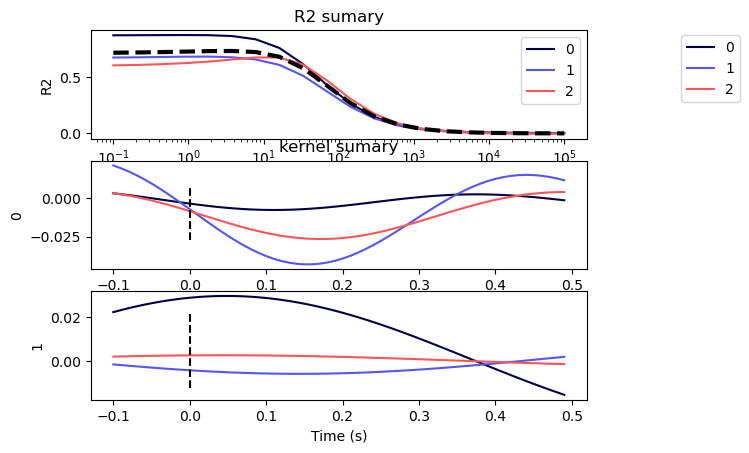

In [1021]:
fig, ax = plt.subplots(3)

trf.plot_score(figax = (fig, ax[0]), color_type = 'seismic')
trf.plot_kernel(figax = (fig, ax[1:]), color_type = 'seismic')

## Correlated Stimuli


(0.0, 10000.0)

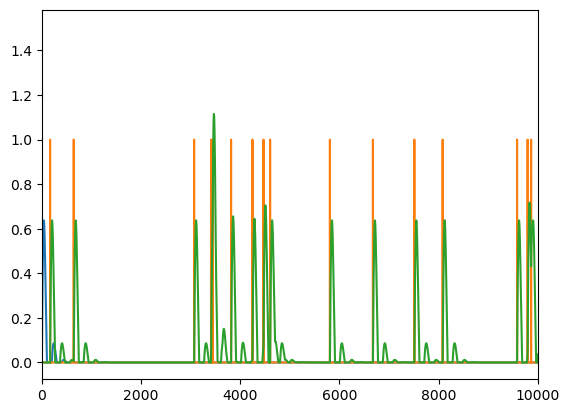

In [52]:


fig, ax = plt.subplots()
stim1 = np.clip(np.sin(2*np.pi*f_stim1*time_array),0,1) * np.exp(-time_array)
onsets = np.zeros(time_array.shape)
onsets_time = np.random.randint(0,time_array.shape[0], 100)
onsets[onsets_time] = 1
stim = convolve(stim1, onsets)
ax.plot(stim1)
ax.plot(onsets)
ax.plot(stim)
ax.set_xlim([0,10000])

## On variance partitioning

## Metrics

In [1022]:
tmin = -0.1
tmax = 0.5
trf = models.TRF.TRFEstimator(tmin=tmin, tmax=tmax, srate = fs, alpha = [0] + np.logspace(-5,5,20))

X = scale(X)
Y = scale(Y)

import time
start = time.time()
print(time.time() - start)
scores = trf.xval_eval(X, Y, scoring = 'ezekiel')
print(time.time() - start)

3.2901763916015625e-05
Training/Evaluating fold 1/5
Training/Evaluating fold 2/5
Training/Evaluating fold 3/5
Training/Evaluating fold 4/5
Training/Evaluating fold 5/5
Fitting full model...
0.7067599296569824


(<Figure size 500x500 with 1 Axes>,
 <Axes: title={'center': 'R2 sumary'}, xlabel='Alpha', ylabel='R2'>)

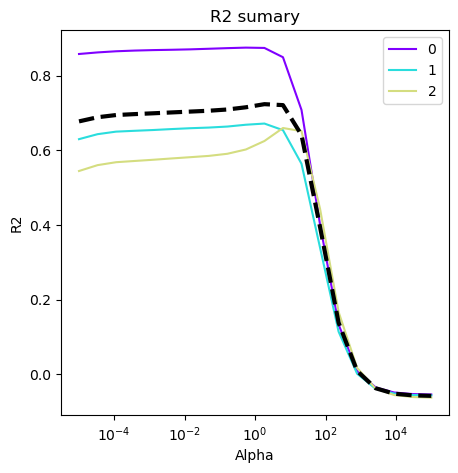

In [1023]:
trf.plot_score()

(<Figure size 500x500 with 1 Axes>,
 <Axes: title={'center': 'R2 sumary'}, xlabel='Alpha', ylabel='R2'>)

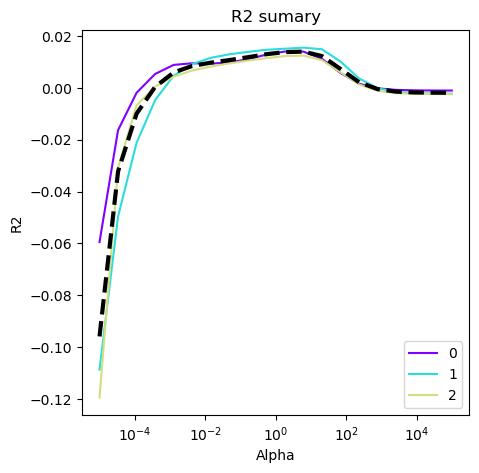

In [979]:
trf.plot_score()

## Sparse Stimuli

In [40]:
yhat.shape

(60000, 3, 20)

In [116]:
X.shape

(60000, 2)

## Should I add more time to my window?

## Pink Noise

(0.0, 10.0)

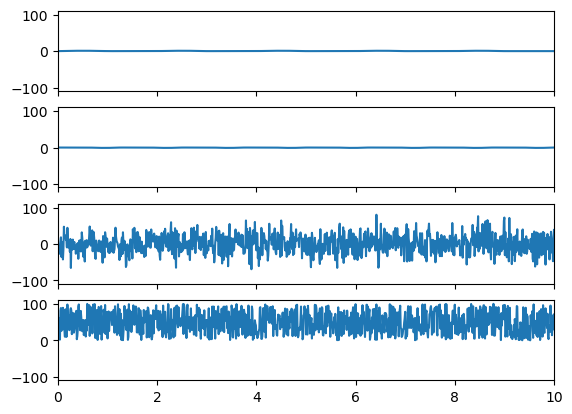

In [39]:
import colorednoise as cn

beta = 0.1 # the exponent

electrophysiological_data = np.hstack([np.roll(stimuli_pos,5) + cn.powerlaw_psd_gaussian(beta, stimuli_pos.shape[0])[:,np.newaxis]*25, 
                                        np.roll(stimuli_pos,5) + np.random.random(stimuli_pos.shape[0])[:,np.newaxis] * 100])
fig, ax = plt.subplots(4, sharex = True, sharey=True)
ax[0].plot(time_array, stimuli_pos)
ax[1].plot(time_array, stimuli_neg)
ax[2].plot(time_array,electrophysiological_data[:,0])
ax[3].plot(time_array,electrophysiological_data[:,1])
ax[0].set_xlim([0,10])

In [40]:
tmin = -1
tmax = 1
trf = models.TRF.TRFEstimator(tmin=tmin, tmax=tmax, srate = fs, alpha = [0] + np.logspace(-10,10,20))

In [41]:
X = scale(np.hstack([stimuli_pos, stimuli_neg]))
Y = scale(electrophysiological_data)

scores = trf.xval_eval(X, Y, scoring = 'R2')

Training/Evaluating fold 1/5
Training/Evaluating fold 2/5
Training/Evaluating fold 3/5
Training/Evaluating fold 4/5
Training/Evaluating fold 5/5
Fitting full model...


(0.0, 0.0003)

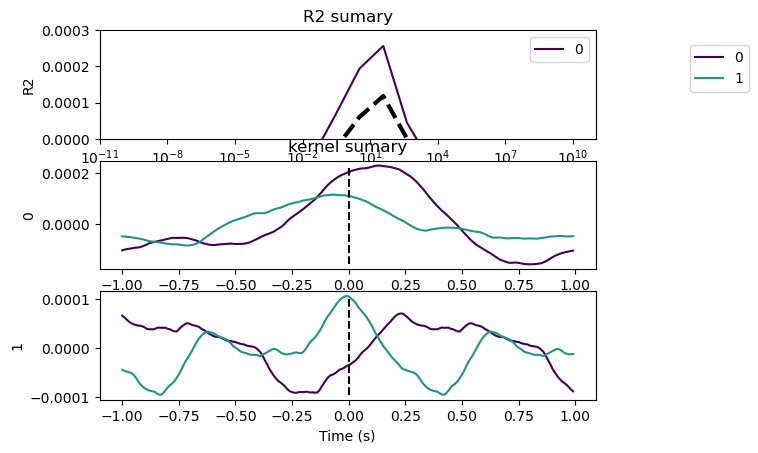

In [43]:
fig, ax = plt.subplots(3)

trf.plot_score(figax = (fig, ax[0]),minR2 = 0, color_type = 'viridis')
trf.plot_kernel(figax = (fig, ax[1:]), color_type = 'viridis')
ax[0].set_ylim(0,0.0003)

# iRRR

In [493]:
%load_ext autoreload
%autoreload 2

# Spyeeg import
import spyeeg.models as models

# Other useful imports
import numpy as np
import matplotlib.pyplot as plt
import mne
import scipy.signal as signal
from sklearn.preprocessing import scale
from scipy.signal import convolve

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [494]:
tmin = -0.1
tmax = 0.5
trf = models.TRF.TRFEstimator(tmin=tmin, tmax=tmax, srate = fs, alpha = [0] + np.logspace(-2,2,5))
irrr = models.iRRR.iRRREstimator(tmin=tmin, tmax=tmax, srate = fs, lambda0 = np.logspace(-2,2,5), lambda1 = np.logspace(-2,2,5))

X = scale(X)
Y = scale(Y)

scores = trf.xval_eval(X, Y, scoring = 'R2')
scores_iRRR = irrr.xval_eval(X, Y, scoring = 'R2')

Training/Evaluating fold 1/5
Training/Evaluating fold 2/5
Training/Evaluating fold 3/5
Training/Evaluating fold 4/5
Training/Evaluating fold 5/5
Fitting full model...
Training/Evaluating fold 1/5
Training/Evaluating fold 2/5
Training/Evaluating fold 3/5
Training/Evaluating fold 4/5
Training/Evaluating fold 5/5


In [495]:
scores.mean(0).max(1)

array([0.88854053, 0.989835  , 0.98409402])

In [496]:
scores_iRRR.mean(0).max((1,2))

array([-0.00022738,  0.00074596, -0.00066178])

(<Figure size 1500x800 with 2 Axes>,
 array([<Axes: title={'center': 'kernel sumary'}, xlabel='Time (s)', ylabel='0'>,
        <Axes: xlabel='Time (s)', ylabel='1'>], dtype=object))

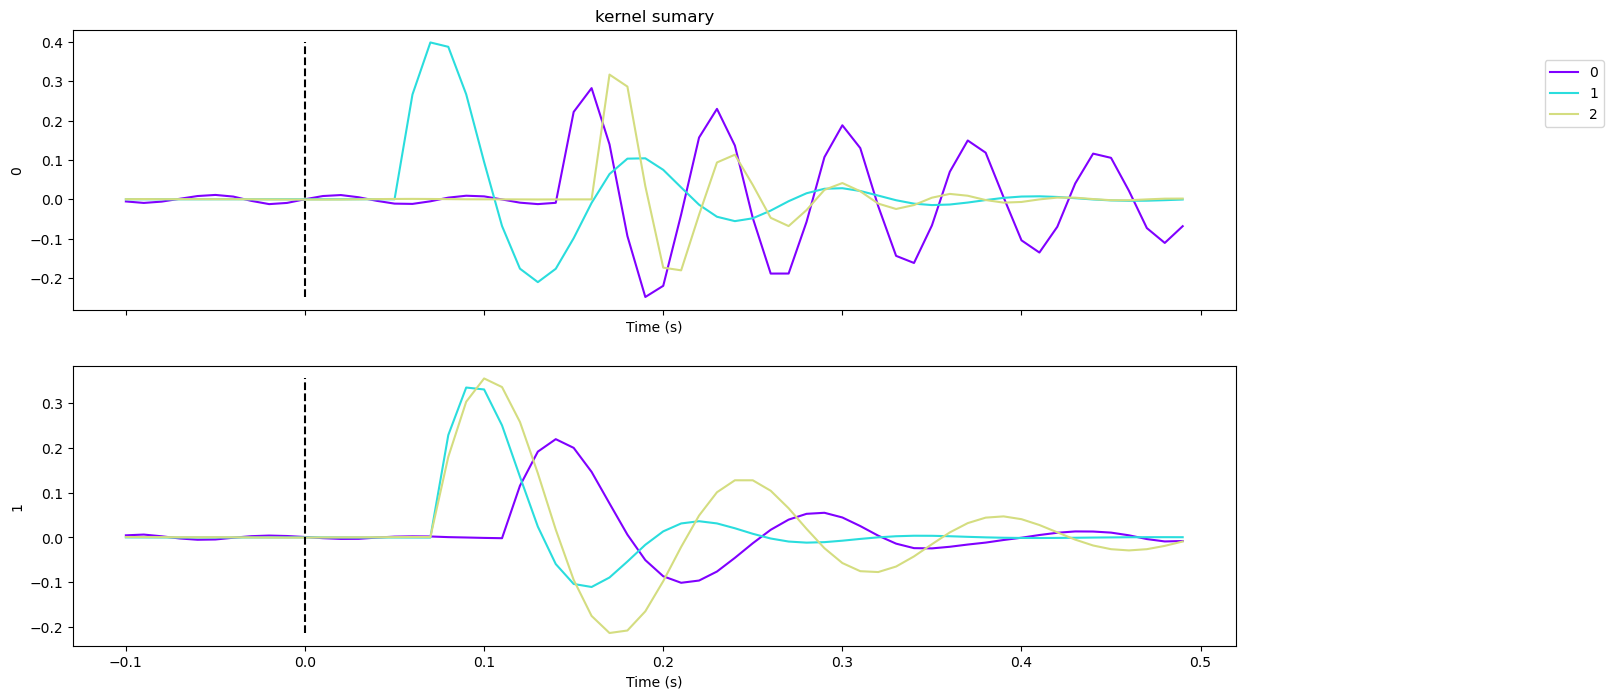

In [497]:
trf.plot_kernel()

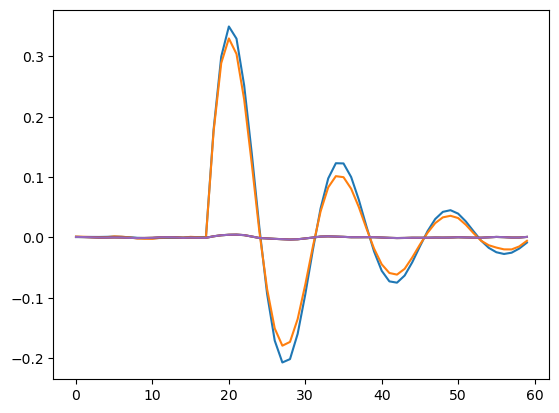

In [498]:
for i in range(5):
    plt.plot(np.asarray(irrr.get_coef())[0,:,1,2,0,i])


# ERP object

In [499]:
%load_ext autoreload
%autoreload 2

# Spyeeg import
import spyeeg.models as models

# Other useful imports
import numpy as np
import matplotlib.pyplot as plt
import mne
import scipy.signal as signal
from sklearn.preprocessing import scale
from scipy.signal import convolve

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


(<Figure size 1000x500 with 1 Axes>,
 <Axes: title={'center': 'ERP'}, xlabel='Time (s)', ylabel='ERP (V)'>)

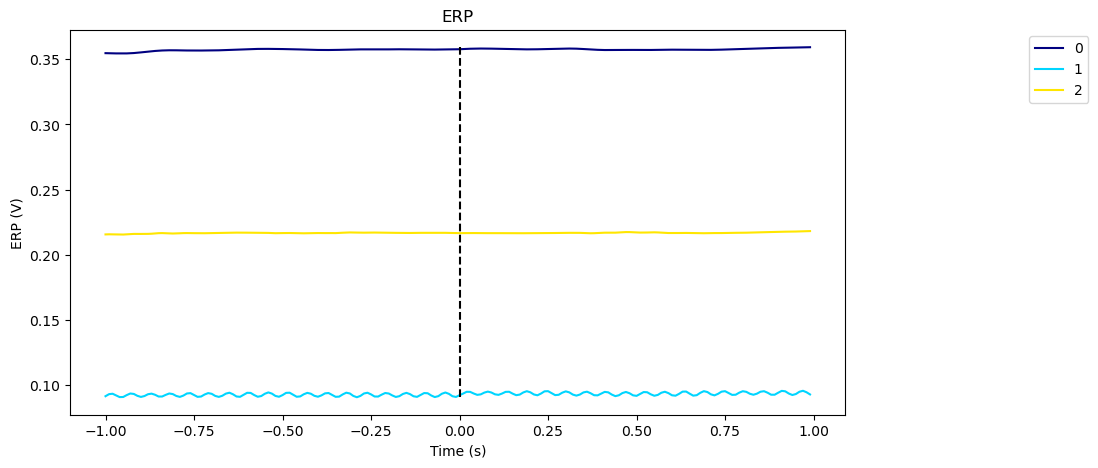

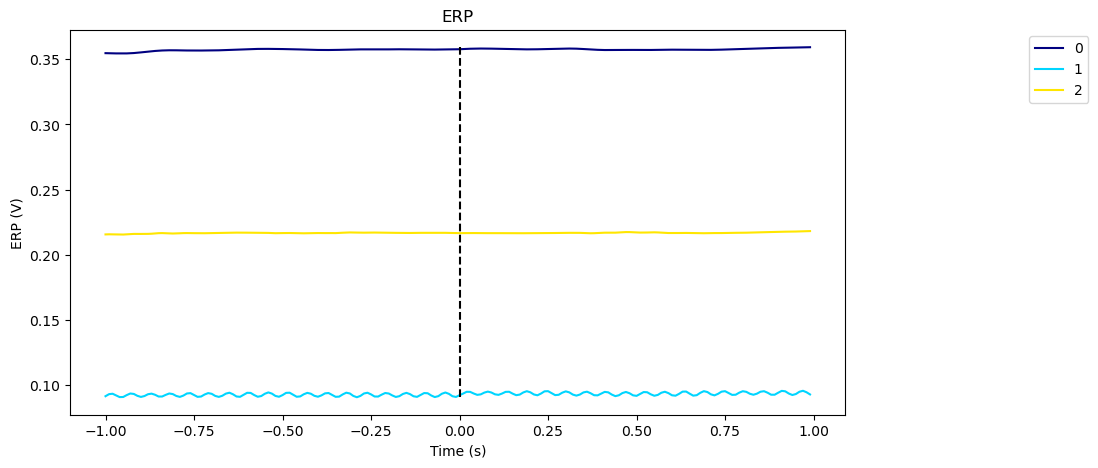

In [503]:
tmin, tmax = -1,1
X = scale(X, with_mean = False, with_std = False)
Y = scale(Y, with_mean = False, with_std = False)

erp1 = models.ERP.ERP_class(tmin, tmax, fs)
erp1.add_continuous_signal(Y, X[:,0], step = 1, weight_events = False)
erp2 = models.ERP.ERP_class(tmin, tmax, fs)
erp2.add_continuous_signal(Y, X[:,1], step = 1, weight_events = False)
erp1.plot_ERP()
erp2.plot_ERP()

(<Figure size 1000x500 with 1 Axes>,
 <Axes: title={'center': 'ERP'}, xlabel='Time (s)', ylabel='ERP (V)'>)

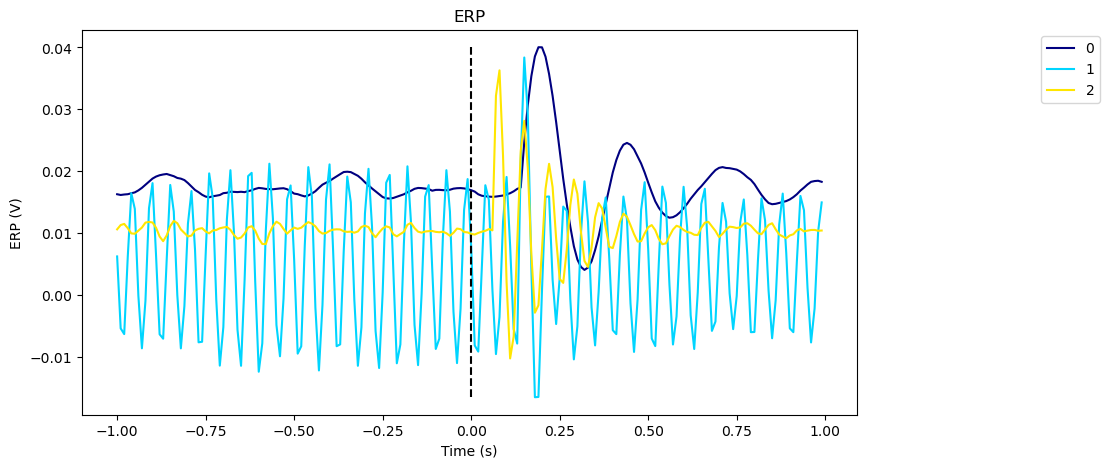

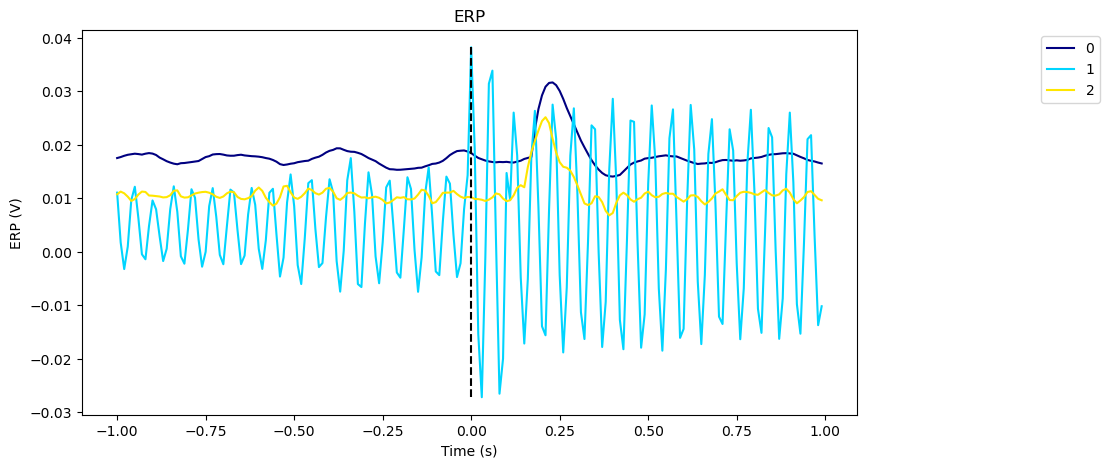

In [504]:
erp1 = models.ERP.ERP_class(tmin, tmax, fs)
erp1.add_continuous_signal(Y, X[:,0], step = 1, weight_events = True)
erp2 = models.ERP.ERP_class(tmin, tmax, fs)
erp2.add_continuous_signal(Y, X[:,1], step = 1, weight_events = True)
erp1.plot_ERP()
erp2.plot_ERP()

# b2b

In [1245]:
%load_ext autoreload
%autoreload 2

# Spyeeg import
import spyeeg.models as models

# Other useful imports
import numpy as np
import matplotlib.pyplot as plt
import mne
import scipy.signal as signal
from sklearn.preprocessing import scale
from scipy.signal import convolve

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
"""
This script contains the code for Back-to-Back regression (b2b).
It was originally proposed in:
    King, J. R., Charton, F., Lopez-Paz, D., & Oquab, M. (2020). 
    Back-to-back regression: Disentangling the influence of correlated 
    factors from multivariate observations. NeuroImage, 220, 117028.

Since the original code is not available, this script was written based on the description in the above paper,
and on the description of its implementation in:
    Gwilliams, L., Marantz, A., Poeppel, D., & King, J. R. (2024). 
    Hierarchical dynamic coding coordinates speech comprehension in the brain. bioRxiv, 2024-04.

When to use B2B regression?
B2B regression allows to perform many-to-many regression. It is an improvement over multivariate decoding,
which can only estimate the relation between multiple channels and a single feature (many-to-one). Multivariate
decoding is limited when the features to be decoded are correlated.
It is in these situations that B2B regression is useful, as it can disentangle the influence of multiple correlated features
on multiple channels.

How does B2B regression work?
The principle of B2B is to first perform a regular decoding on half of the data, and then use the second half to perform another 
regression from all true features to each estimated feature. This second regression retrieves the unique relation 
between a true feature and its estimation, knowing all other true features.
Thus, B2B outputs the diagonal of a causal influence matrix, which represents the influence of each feature on all channels. 
The values obtained are beta coefficients. If beta values for a given feature is above 0, it is encoded in the neural signal. 
Note that B2B does not assess significance.

I still don't understand the output of B2B. Can you tell me more ?
In the theorical case where there is no noise in the data, the diagonal of the causal influence matrix S would be a binary matrix.
If a feature i has some influence on the neural data, Sii = 1. If not, Sii = 0. In practice, the noise in the data will make
the estimation fluctuate. The use of Ridge regression allows to reduce the influence of noise, but will produce smaller values in S.
Thus, a practical work-around is to replicate the analysis on multiple subject, and to test whether Sii is significantly above 0.
Note that the values in S are relative to the effect size and to the SNR. 
These values are beta coefficients, and should not be interpreted as explained variance. 
"""


import numpy as np
from scipy.stats import zscore
from sklearn.linear_model import RidgeCV, LinearRegression
from sklearn.model_selection import train_test_split
from joblib import Parallel, delayed

def b2b_compute(X, Y, alphas1 = np.logspace(-5, 5, 20), alphas2 = np.logspace(-5, 5, 20), n_folds = 100, normalize = True, n_jobs = -1):
    """
    X: np.array of shape (n_trials, n_features), features. 
    Y: np.array of shape (n_trials, n_channels, n_timepoints), recorded neural signal.
    alphas: np.array, regularization parameters
    n_folds: int, number of folds for cross-validation
    normalize: bool, whether to normalize (zscore) the data or not.
            If True, normalization is done across trials, for each feature, channel and timepoint separately.
            Note that data has to be at least centered for B2B to work.

    returns:
    S: np.array of shape (n_features, n_timepoints), estimated causal influence matrix per timepoint
    """

    _, n_features = X.shape
    _, n_channels, n_timepoints = Y.shape
    print('-- Starting B2B regression --')

    #normalize input data
    if normalize:
        X = zscore(X, axis=0)
        for c in range(n_channels):
            Y[:,c,:] = zscore(Y[:,c,:], axis=0)

    #for each fold
    S = np.zeros((n_features, n_timepoints, n_folds))
    for i_fold in range(n_folds):
        #random half-split of data
        np.random.seed(i_fold)
        X1, X2, Y1, Y2 = train_test_split(X, Y, test_size=0.5)
        if i_fold % 10 == 0:
            print('Computing fold', i_fold+1, '/', n_folds)

        #define b2b function for parallel processing
        def b2b_(t):
            y1 = Y1[:,:,t]
            y2 = Y2[:,:,t]

            #predict each feature Xi from all channels Y (i.e. decoding)
            reg1 = RidgeCV(alphas=alphas1, fit_intercept=False, cv = None, scoring = 'neg_mean_squared_error') #with cv = None, efficient Leave-One-Out is used
            reg1.fit(y1, X1)
            G = reg1.coef_.T

            #predict each estimated feature Xi from all true features X
            # reg2 = LinearRegression(fit_intercept=False) #King et al., 2020
            reg2 = RidgeCV(alphas=alphas2, fit_intercept=False, cv = None, scoring = 'neg_mean_squared_error') #Gwilliams et al., 2024
            reg2.fit(X2, np.dot(y2, G))
            H = reg2.coef_.T

            #return causal influence matrix
            return H.diagonal()

        #run b2b for each timepoint separately
        s = Parallel(n_jobs=n_jobs)(delayed(b2b_)(t) for t in range(n_timepoints))
        for t in range(n_timepoints):
            S[:,t, i_fold] = s[t]
    
    #average across folds
    S = S.mean(axis=2)

    return S

tmin = -0.1
tmax = 0.5
trf = models.TRF.TRFEstimator(tmin=tmin, tmax=tmax, srate = fs, alpha = [0] + np.logspace(-2,2,5))

scores = trf.xval_eval(X, Y, scoring = 'R2')

In [647]:
erp = models.ERP.ERP_class(tmin,tmax,fs)
erp.add_continuous_signal(Y, X[:,0], step = 1, weight_events = False)
Yepochs = np.asarray(erp.evoked).swapaxes(1,2)
X1epochs = np.asarray(erp.weights)

erp = models.ERP.ERP_class(tmin,tmax,fs)
erp.add_continuous_signal(Y, X[:,1], step = 1, weight_events = False)
X2epochs = np.asarray(erp.weights)

Xepochs = np.vstack([X1epochs, X2epochs]).T

In [648]:
scores_b2b = b2b_compute(Xepochs,Yepochs, n_folds = 100)

-- Starting B2B regression --
Computing fold 1 / 100
Computing fold 11 / 100
Computing fold 21 / 100
Computing fold 31 / 100
Computing fold 41 / 100
Computing fold 51 / 100
Computing fold 61 / 100
Computing fold 71 / 100
Computing fold 81 / 100
Computing fold 91 / 100


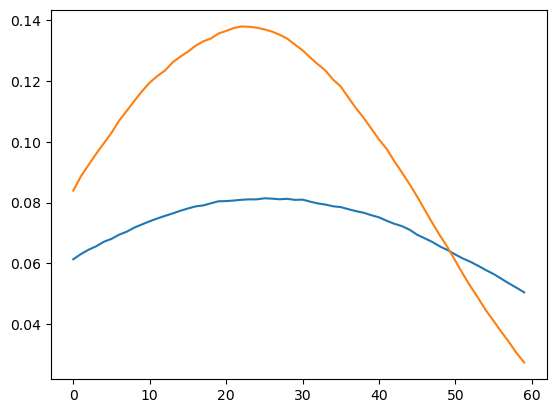

In [649]:
plt.plot(scores_b2b[0])
plt.plot(scores_b2b[1])

# ESN

In [1300]:
import reservoirpy
from spyeeg.models.ESN import ESNEstimator
from sklearn.model_selection import train_test_split

tmin, tmax = -0.1,0.5
trf = models.TRF.TRFEstimator(tmin=tmin, tmax=tmax, srate = fs, alpha = [0] + np.logspace(-2,5,20))
scores_trf = trf.xval_eval(X, Y, scoring = 'R2')
scores_trf = scores_trf.mean(0).max(-1)

Training/Evaluating fold 1/5
Training/Evaluating fold 2/5
Training/Evaluating fold 3/5
Training/Evaluating fold 4/5
Training/Evaluating fold 5/5
Fitting full model...


In [1303]:
esn = ESNEstimator(srate = fs, alpha = np.logspace(-10,5,40), n_units = 50, 
                   percentile_units = 0, separate_features = True, scale_reservoir = False)
scores_esn = esn.xval_eval(X,Y)
scores_esn = scores_esn.mean(0).max(-1)

Training/Evaluating fold 1/5


Running Reservoir-130: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 12000/12000 [00:00<00:00, 14107.11it/s]


Training/Evaluating fold 2/5


Running Reservoir-130: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 12000/12000 [00:00<00:00, 14313.41it/s]


Training/Evaluating fold 3/5


Running Reservoir-130: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 12000/12000 [00:00<00:00, 13703.25it/s]


Training/Evaluating fold 4/5


Running Reservoir-130: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 12000/12000 [00:00<00:00, 16587.07it/s]


Training/Evaluating fold 5/5


Running Reservoir-130: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 12000/12000 [00:00<00:00, 16662.71it/s]


Fitting full model...


Running Reservoir-130: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 60000/60000 [00:03<00:00, 17193.47it/s]


[0.00557174]


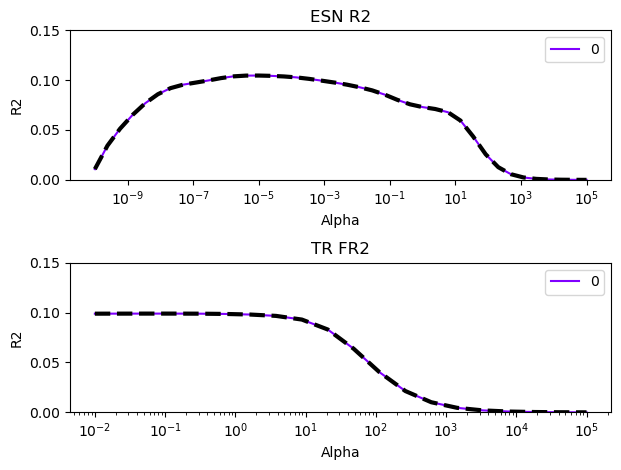

In [1304]:
fig, ax = plt.subplots(2, sharey = True)
esn.plot_score(figax = (fig, ax[0]))
trf.plot_score(figax = (fig, ax[1]))

ax[0].set_ylim(0,0.15)
ax[0].set_title('ESN R2')
ax[1].set_title('TR FR2')
fig.tight_layout()
print(scores_esn - scores_trf)

In [1274]:
X.shape

(12000, 4)

# ERP regression

In [958]:
start = time.time()
np.linalg.norm(X)**2
print(time.time() - start)

0.0001442432403564453


In [959]:
start = time.time()
np.trace(X.T@X)
print(time.time() - start)

0.0001270771026611328
